In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
import math

In [5]:
class Risk_Calculation_System:
    
    def __init__(self, S0, T, p_var, p_es, l, M, Stocks=None):
        """
        Initialize the Risk Calculation System with given parameters.

        Parameters:
        - S0: Initial investment amount
        - T: Time horizon in years
        - p_var: Confidence level for Value at Risk (VaR)
        - p_es: Confidence level for Expected Shortfall (ES)
        - l: Lookback period for historical methods
        - M: Number of Monte Carlo simulations
        - Stocks: List of tuples containing file paths and positions 
                  for individual stocks in the portfolio
        """
        
        self.S0 = S0
        self.T = T
        self.p_var = p_var
        self.p_es = p_es
        self.l = l
        self.M = M
        
        self.portfolio = None
        self.stock_data_dict = None
        
        if (Stocks != None):
            self.preprocess_data(Stocks)
            self.read_stocks_data(Stocks)
            self.position1 = Stocks[0][1]
            self.position2 = Stocks[1][1]
    

    
    def preprocess_data(self,Stocks):
        
        """
        Preprocess stock data and create a portfolio dataframe.

        Parameters:
        - Stocks: List of tuples containing file paths and positions 
          for individual stocks in the portfolio
        """
        
        self.portfolio = pd.DataFrame()  
        
        for stock in Stocks:
            file_path, position = stock
            try:
                new_stock = pd.read_csv(file_path)
            except:
                print("Error reading data")
                return
        
        new_stock['Dates'] = pd.to_datetime(new_stock['Dates'])
        new_stock.set_index('Dates', inplace=True)
        new_stock['PX_LAST'] *= position

        if self.portfolio.empty:
            self.portfolio = new_stock[['PX_LAST']].copy()
            self.portfolio.columns = ['PX_LAST']
        else:
            self.portfolio = pd.merge(self.portfolio, new_stock[['PX_LAST']], 
                                      left_index=True, right_index=True, how='outer')
        
        self.portfolio.fillna(0.001, inplace=True)  # Handle missing values
        self.portfolio['PX_LAST'] = self.portfolio.sum(axis=1)
        self.portfolio['LogReturn'] = np.log(self.portfolio['PX_LAST'] / 
                                             self.portfolio['PX_LAST'].shift(1))

        return self.portfolio
    
    
    
    def read_stocks_data(self,Stocks):
        
        """
        Read stock data for individual tickers into a dictionary.

        Parameters:
        - Stocks: List of tuples containing file paths and positions for 
          individual stocks in the portfolio
        """
        
        self.stock_data_dict = {}
        
        for stock in Stocks:
            file_path = stock[0]
            stock_ticker = file_path.split('/')[-1].split('.')[0]
            stock_df = pd.read_csv(file_path)
            stock_df['Dates'] = pd.to_datetime(stock_df['Dates'])
            stock_df.set_index('Dates', inplace=True)
            self.stock_data_dict[stock_ticker] = stock_df
        
        return self.stock_data_dict

    
    
    def calculate_mu_sigma(self,yr):
        """
        Calculate the estimated drift and volatility using rolling window.

        Parameters:
        - yr: Lookback period in years
        """
        
        dt = 1/252
        results_mu = pd.Series(index=self.portfolio.index)
        results_sigma = pd.Series(index=self.portfolio.index)
        
        mu_bar = self.portfolio['LogReturn'].rolling(window=yr*252).mean()
        var_bar = ((self.portfolio['LogReturn']**2).rolling(window=yr*252).mean())-mu_bar**2
        sigma_bar = np.sqrt(var_bar)
        
        results_sigma = sigma_bar/np.sqrt(dt)
        results_mu = mu_bar/dt+results_sigma**2/2
        
        self.portfolio['sigma'] = results_sigma
        self.portfolio['mu'] = results_mu
        
        return results_mu, results_sigma
    
    
    
    def calculate_exp_mu_sigma(self, lmbda, stock_df):
        """
        Calculate the estimated drift and volatility using exponential weighting.

        Parameters:
        - lmbda: Lambda value for exponential weighting
        - stock_df: DataFrame containing stock price data
        """
        
        df_copy = stock_df.sort_index(ascending=False)
        prices = df_copy['PX_LAST']
        
        rtn = -np.diff(np.log(prices))
        rtnsq = rtn * rtn
        windowLen = min(int(np.ceil(np.log(0.01)/np.log(lmbda))),2000)
        
        w = np.array([lmbda ** i for i in range (windowLen)])
        w /= w.sum ()
        
        n = len(prices)-windowLen+1
        sigma = pd.Series(index=prices.index)
        mu = pd.Series(index=prices.index)
        
        for x in range(n):
            end = min(x+windowLen,n)
            w_adj = w[:end-x]
            rtn_seg = rtn[x:end]
            mubar = np.sum(rtn_seg*w_adj)
            rtnsq_seg = rtnsq[x:end]
            x2bar = np.sum(rtnsq_seg*w_adj)
            
            var = x2bar-mubar**2
            sigmabar = np.sqrt(np.maximum(var,0))
            Sigma = sigmabar/np.sqrt(1/252)
            Mu = mubar/(1/252)+Sigma**2/2
            
            sigma[x] = Sigma
            mu[x] = Mu
        sigma = sigma.sort_index()
        mu = mu.sort_index()
        
        return mu, sigma
    


    def plot_mu_sigma(self, mu, sigma):
        """
        Plot the estimated drift and volatility in the same plot.

        Parameters:
        - mu: Series containing estimated drift values
        - sigma: Series containing estimated volatility values
        """
        
        sigma = sigma[len(sigma)-12*252:]
        mu = mu[len(mu)-12*252:]
        plt.figure(figsize=(18, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(mu, label='mu', linestyle='-')
        plt.title('Drift of the portfolio')
        plt.xlabel('Date')
        plt.ylabel('Drift')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(sigma, label='sigma', linestyle='-')
        plt.title('Volatility of the portfolio')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        
        
    def para_normal_dis_long_VaR_ES(self, lmbda):
        '''
        Calculate Parametric VaR and ES for a long position assuming 
        normal distribution.

        Parameters:
        - lmbda: Lambda value for exponential weighting
        '''

        a = self.position1
        b = self.position2
        S_H0 = self.S0 / 2 / a
        S_U0 = self.S0 / 2 / b
        t = self.T

        long_VaR_normal = pd.Series(index=self.portfolio.index)
        long_ES_normal = pd.Series(index=self.portfolio.index)

        first_stock_key = list(self.stock_data_dict.keys())[0]
        stock_1 = self.stock_data_dict[first_stock_key]
        second_stock_key = list(self.stock_data_dict.keys())[1]
        stock_2 = self.stock_data_dict[second_stock_key]

        stock_1['Return'] = np.log(stock_1['PX_LAST'] / stock_1['PX_LAST'].shift(1))
        stock_2['Return'] = np.log(stock_2['PX_LAST'] / stock_2['PX_LAST'].shift(1))
        cov = np.cov(stock_1['Return'][len(stock_1)-12*252:], stock_2['Return']
                     [len(stock_2)-12*252:])[0, 1]

        exp_mu_1, exp_sigma_1 = self.calculate_exp_mu_sigma(lmbda, stock_1)
        exp_mu_2, exp_sigma_2 = self.calculate_exp_mu_sigma(lmbda, stock_2)

        def mu_sigma(mu_H, sigma_H, mu_U, sigma_U):
            rho = cov / (sigma_H * sigma_U * self.T)
            m_s_r = mu_H + mu_U + rho * sigma_H * sigma_U
            E_S1S2 = S_H0 * S_U0 * np.exp(m_s_r)
            E_V = a * S_H0 * np.exp(mu_H * t) + b * S_U0 * np.exp(mu_U * t)
            E_V2 = a**2*S_H0**2*np.exp(2*mu_H*t+sigma_H**2*t)+b**2*S_U0**2*np.exp(2*mu_U*t+sigma_U**2*t)+2*a*b*S_H0*S_U0*np.exp(m_s_r*t)
            sd_V = np.sqrt(E_V2 - E_V**2)
            return E_V, sd_V

        def long_var_normal(mu, sigma, p):
            z = norm.ppf(p)
            return self.S0 - (mu - z * sigma)

        def long_es_normal(sigma, p):
            Z = norm.ppf(p)
            ES = (np.exp(-0.5 * Z**2)) / ((1 - p) * np.sqrt(2 * math.pi)) * sigma
            return ES

        for date in exp_mu_1.index:
            mu_H = exp_mu_1[date]
            sigma_H = exp_sigma_1.loc[date]
            mu_U = exp_mu_2.loc[date]
            sigma_U = exp_sigma_2.loc[date]
            mu, sigma = mu_sigma(mu_H, sigma_H, mu_U, sigma_U)
            var = long_var_normal(mu, sigma, self.p_var)
            es = long_es_normal(sigma, self.p_es)

            long_VaR_normal.loc[date] = var
            long_ES_normal.loc[date] = es

        return long_VaR_normal, long_ES_normal

    
    
    
    def para_normal_dis_short_VaR_ES(self, lmbda):
        '''
        Calculate Parametric VaR and ES for a short position assuming normal distribution.

        Parameters:
        - lmbda: Lambda value for exponential weighting
        '''

        a = self.position1
        b = self.position2
        S_H0 = self.S0 / 2 / a
        S_U0 = self.S0 / 2 / b
        t = self.T

        short_VaR_normal = pd.Series(index=self.portfolio.index)
        short_ES_normal = pd.Series(index=self.portfolio.index)

        first_stock_key = list(self.stock_data_dict.keys())[0]
        stock_1 = self.stock_data_dict[first_stock_key]
        second_stock_key = list(self.stock_data_dict.keys())[1]
        stock_2 = self.stock_data_dict[second_stock_key]

        stock_1['Return'] = np.log(stock_1['PX_LAST'].shift(1) / stock_1['PX_LAST'])
        stock_2['Return'] = np.log(stock_2['PX_LAST'].shift(1) / stock_2['PX_LAST'])
        cov = np.cov(stock_1['Return'][len(stock_1)-12*252:], stock_2['Return'][len(stock_2)-12*252:])[0, 1]

        exp_mu_1, exp_sigma_1 = self.calculate_exp_mu_sigma(lmbda, stock_1)
        exp_mu_2, exp_sigma_2 = self.calculate_exp_mu_sigma(lmbda, stock_2)

        def mu_sigma(mu_H, sigma_H, mu_U, sigma_U):
            rho = cov / (sigma_H * sigma_U * self.T)
            m_s_r = mu_H + mu_U + rho * sigma_H * sigma_U
            E_S1S2 = S_H0 * S_U0 * np.exp(m_s_r)
            E_V = a * S_H0 * np.exp(mu_H * t) + b * S_U0 * np.exp(mu_U * t)
            E_V2 = a**2 * S_H0**2 * np.exp(2 * mu_H * t + sigma_H**2 * t) + b**2 * S_U0**2 * np.exp(2 * mu_U * t + sigma_U**2 * t) + 2 * a * b * S_H0 * S_U0 * np.exp(m_s_r * t)
            sd_V = np.sqrt(E_V2 - E_V**2)
            return E_V, sd_V

        def short_var_normal(mu, sigma, p):
            z = norm.ppf(p)
            return -self.S0 + (mu - z * sigma)

        def short_es_normal(sigma, p):
            Z = norm.ppf(p)
            ES = (np.exp(-0.5 * Z**2)) / ((1 - p) * np.sqrt(2 * math.pi)) * sigma
            return -ES

        for date in exp_mu_1.index:
            mu_H = exp_mu_1[date]
            sigma_H = exp_sigma_1.loc[date]
            mu_U = exp_mu_2.loc[date]
            sigma_U = exp_sigma_2.loc[date]
            mu, sigma = mu_sigma(mu_H, sigma_H, mu_U, sigma_U)
            var = short_var_normal(mu, sigma, self.p_var)
            es = short_es_normal(sigma, self.p_es)

            short_VaR_normal.loc[date] = var
            short_ES_normal.loc[date] = es

        return short_VaR_normal, short_ES_normal


    def para_long_VaR_ES(self, mu, sigma):
        """
        Calculate Parametric VaR and ES for a long position.

        Parameters:
        - mu: Series of estimated drift values
        - sigma: Series of estimated volatility values
        """
            
        para_long_VaR = pd.Series(dtype=float)
        para_long_ES = pd.Series(dtype=float)
        
        def long_VaR(drift, volatility):
            z = norm.ppf(1 - self.p_var)
            VaR = self.S0 - self.S0 * np.exp(volatility * np.sqrt(self.T) * z + (drift - volatility**2/2) * self.T)
            return VaR
        def long_ES(drift, volatility):
            z_ES = norm.ppf(1 - self.p_es)
            ES = self.S0 - (self.S0 * np.exp(drift * self.T) * norm.cdf(z_ES - volatility * np.sqrt(self.T))) / (1 - self.p_es)
            return ES
        for j in range(len(self.portfolio)):
            drift = mu.iloc[j]
            volatility = sigma.iloc[j]
            para_long_VaR.loc[j] = long_VaR(drift, volatility)
            para_long_ES.loc[j] = long_ES(drift, volatility)
        
        para_long_VaR.index = self.portfolio.index
        para_long_ES.index = self.portfolio.index
        
        return para_long_VaR, para_long_ES
    
    
    
    def para_short_VaR_ES(self, mu, sigma):
        """
        Calculate Parametric VaR and ES for a short position.

        Parameters:
        - mu: Series of estimated drift values
        - sigma: Series of estimated volatility values
        """
        
        para_short_VaR = pd.Series(dtype=float)
        para_short_ES = pd.Series(dtype=float)
        
        def short_VaR(drift, volatility):
            z = norm.ppf(self.p_var)
            VaR = -self.S0+self.S0*np.exp(volatility*np.sqrt(self.T)*z+(drift-volatility**2/2)*self.T)
            return VaR
        def short_ES(drift, volatility):
            z = norm.ppf(self.p_es)
            ES = -self.S0+(self.S0*np.exp(drift*self.T)*(1-norm.cdf(z-volatility*np.sqrt(self.T))))/(1-self.p_es)
            return ES
        
        for j in range(len(self.portfolio)):
            drift = mu.iloc[j]
            volatility = sigma.iloc[j]
            para_short_VaR.loc[j] = short_VaR(drift, volatility)
            para_short_ES.loc[j] = short_ES(drift, volatility)
            
        para_short_VaR.index = self.portfolio.index
        para_short_ES.index = self.portfolio.index
        
        return para_short_VaR, para_short_ES
    
    
    
    def historical_sample(self,l,i):
        """
        Extract historical sample for a given time point.

        Parameters:
        - l: Lookback period in years
        - i: Index for the time point
        """
        
        log_rtn = self.portfolio['LogReturn'].rolling(5).sum()
        historical_sample =log_rtn.iloc[i-252*l:i]
        historical_sample = np.exp(historical_sample)*self.S0
        
        return historical_sample
    
    
    
    def hist_long_VaR_ES(self, mu, sigma):
        """
        Calculate Historical VaR and ES for a long position.

        Parameters:
        - mu: Series of estimated drift values
        - sigma: Series of estimated volatility values
        """
        
        his_long_VaR = pd.Series(dtype=float)
        his_long_ES = pd.Series(dtype=float)
        
        def long_hVaR(historical_sample):
            sorted_historical_sample = np.sort(historical_sample)
            index = int(self.l*252 * (1 - self.p_var))
            return self.S0 - sorted_historical_sample[index]
        def long_hES(historical_sample):
            sorted_historical_sample = np.sort(historical_sample)
            index = int(self.l*252 * (1 - self.p_es))
            loss = self.S0 - sorted_historical_sample[:index]
            ES = sum(loss) / len(loss)
            return ES

        k = 0
        df = self.portfolio
        for i in range(len(df)-12*252,len(df)):
            k = k+1
            h_sample = self.historical_sample(self.l,i)
            his_long_VaR.loc[k] = long_hVaR(h_sample)
            his_long_ES.loc[k] = long_hES(h_sample)
        his_long_VaR.index = df.index[len(df)-12*252:len(df)]
        his_long_ES.index = df.index[len(df)-12*252:len(df)]
        return his_long_VaR, his_long_ES 
    
    
    
    def hist_short_VaR_ES(self, mu, sigma):
        """
        Calculate Historical VaR and ES for a short position.

        Parameters:
        - mu: Series of estimated drift values
        - sigma: Series of estimated volatility values
        """
        
        his_short_VaR = pd.Series(dtype=float)
        his_short_ES = pd.Series(dtype=float)
        
        def short_hVaR(historical_sample):
            sorted_historical_sample = np.sort(historical_sample)
            index = int(self.l*252 * self.p_var)
            return - self.S0 + sorted_historical_sample[index]
        def short_hES(historical_sample):
            sorted_historical_sample = np.sort(historical_sample)
            index = int(self.l*252 * self.p_es)
            loss = - self.S0 + sorted_historical_sample[index:]
            ES = sum(loss) / len(loss)
            return ES
        
        k = 0
        df = self.portfolio
        for i in range(len(df)-12*252,len(df)):
            k = k+1
            h_sample = self.historical_sample(self.l,i)
            his_short_VaR.loc[k] = short_hVaR(h_sample)
            his_short_ES.loc[k] = short_hES(h_sample)
        his_short_VaR.index = df.index[len(df)-12*252:len(df)]
        his_short_ES.index = df.index[len(df)-12*252:len(df)]
        return his_short_VaR, his_short_ES
    
    
    def abs_hist_long_VaR_ES(self,drift,volatility):
        """
        Calculate Historical VaR and ES for a long position assuming absolute change.

        Parameters:
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        def abs_hist_sample(i):
            abs_return = self.portfolio['PX_LAST']-self.portfolio['PX_LAST'].shift(1)
            sum_rtn = abs_return.rolling(5).sum()
            his_sample = sum_rtn.iloc[i-252*5:i]
            his_sample = his_sample*self.S0/self.portfolio['PX_LAST'].iloc[i]
            return his_sample
                            
        def abs_hVaR(sample):
            sorted_sample = np.sort(sample)
            index = int(5*252*self.p_var)
            return sorted_sample[index]
        def abs_hES(sample):
            sorted_sample = np.sort(sample)
            index = int(5*252*self.p_es)
            loss = sorted_sample[index:]
            ES = sum(loss) / len(loss)
            return ES
        
        VaR = pd.Series(dtype=float)
        ES = pd.Series(dtype=float)
        k = 0
        for i in range(len(self.portfolio)-12*252,len(self.portfolio)):
            k = k+1
            h_sample = abs_hist_sample(i)
            VaR.loc[k] = abs_hVaR(h_sample)
            ES.loc[k] = abs_hES(h_sample)
        VaR.index = self.portfolio.index[len(self.portfolio)-12*252:len(self.portfolio)]
        ES.index = self.portfolio.index[len(self.portfolio)-12*252:len(self.portfolio)]
        return VaR, ES
    
    
    
    
    def abs_hist_short_VaR_ES(self,drift,volatility):
        """
        Calculate Historical VaR and ES for a short position assuming absolute change.

        Parameters:
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        def abs_hist_sample(i):
            abs_return = self.portfolio['PX_LAST'].shift(1) - self.portfolio['PX_LAST']
            sum_rtn = abs_return.rolling(5).sum()
            his_sample = sum_rtn.iloc[i-252*5:i]
            his_sample = his_sample*self.S0/self.portfolio['PX_LAST'].iloc[i]
            return his_sample
                            
        def abs_hVaR(sample):
            sorted_sample = np.sort(sample)
            index = int(5*252*self.p_var)
            return sorted_sample[index]
        def abs_hES(sample):
            sorted_sample = np.sort(sample)
            index = int(5*252*self.p_es)
            loss = sorted_sample[index:]
            ES = sum(loss) / len(loss)
            return ES
        
        VaR = pd.Series(dtype=float)
        ES = pd.Series(dtype=float)
        k = 0
        for i in range(len(self.portfolio)-12*252,len(self.portfolio)):
            k = k+1
            h_sample = abs_hist_sample(i)
            VaR.loc[k] = abs_hVaR(h_sample)
            ES.loc[k] = abs_hES(h_sample)
        VaR.index = self.portfolio.index[len(self.portfolio)-12*252:len(self.portfolio)]
        ES.index = self.portfolio.index[len(self.portfolio)-12*252:len(self.portfolio)]
        return VaR, ES
    
    
    
    
    def MC_sample(self, drift, volatility, M, i):
        """
        Generate a Monte Carlo sample of stock prices.

        Parameters:
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        - M: Number of Monte Carlo simulations
        - i: Index for the time point
        """
        mu = drift.iloc[i]
        sigma = volatility.iloc[i]
        W = np.random.normal(0, np.sqrt(self.T), M)
        S_t = self.S0 * np.exp((mu - (sigma ** 2) / 2) * self.T + sigma * W)
        return S_t
    
    
    
    def MC_long_VaR_ES(self, drift, volatility):
        """
        Calculate Monte Carlo VaR and ES for a long position.

        Parameters:
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        MC_long_VaR = pd.Series(dtype=float)
        MC_long_ES = pd.Series(dtype=float)
        
        def long_mc_VaR(sample):
            loss = self.S0 - sample
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        def long_mc_ES(sample):
            loss = self.S0 - sample
            loss = np.sort(loss)
            index = int(self.M * self.p_es)
            loss = loss[index:]
            ES = sum(loss) / len(loss)
            return ES
        
        for i in range(len(self.portfolio)):
            p_sample = self.MC_sample(drift, volatility, self.M, i)
            MC_long_VaR.loc[i] = long_mc_VaR(p_sample)
            MC_long_ES.loc[i] = long_mc_ES(p_sample)
        
        MC_long_VaR.index = self.portfolio.index
        MC_long_ES.index = self.portfolio.index
        return MC_long_VaR, MC_long_ES
    
    
    
    def MC_short_VaR_ES(self, drift, volatility):
        """
        Calculate Monte Carlo VaR and ES for a short position.

        Parameters:
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        MC_short_VaR = pd.Series(dtype=float)
        MC_short_ES = pd.Series(dtype=float)
        
        def short_mc_VaR(sample):
            loss = - self.S0 + sample
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        def short_mc_ES(sample):
            loss = - self.S0 + sample
            loss = np.sort(loss)
            index = int(self.M * self.p_es)
            loss = loss[index:]
            ES = sum(loss) / len(loss)
            return ES
        
        for i in range(len(self.portfolio)):
            p_sample = self.MC_sample(drift, volatility, self.M, i)
            MC_short_VaR.loc[i] = short_mc_VaR(p_sample)
            MC_short_ES.loc[i] = short_mc_ES(p_sample)
        
        MC_short_VaR.index = self.portfolio.index
        MC_short_ES.index = self.portfolio.index
        return MC_short_VaR, MC_short_ES
    
    
    def plot_VaR_ES(self, Type, Trade, drift, volatility):
        """
        Plot VaR and ES values for a specific risk calculation type and trading position.

        Parameters:
        - Type: Risk calculation type ('Parametric', 'Historical', or 'Monte Carlo')
        - Trade: Trading position ('long' or 'short')
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        if Type == 'Parametric (Normal distributed)':
            lmbda = 0.9989003714
            if Trade == 'long':
                VaR, ES = self.para_normal_dis_long_VaR_ES(lmbda)
            elif Trade == 'short':
                VaR, ES = self.para_normal_dis_short_VaR_ES(lmbda)
            else:
                raise ValueError('Wrong Tradr. Please choose long or short.')           
        else:
            if Type == 'Parametric':
                if Trade == 'long':
                    f = self.para_long_VaR_ES
                elif Trade == 'short':
                    f = self.para_short_VaR_ES
                else: 
                    raise ValueError('Wrong Tradr. Please choose long or short.')
            elif Type == 'Historical':
                if Trade == 'long':
                    f = self.hist_long_VaR_ES
                elif Trade == 'short':
                    f = self.hist_short_VaR_ES
                else: 
                    raise ValueError('Wrong Tradr. Please choose long or short.')
            elif Type == 'Historical (absolute change)':
                if Trade == 'long':
                    f = self.abs_hist_long_VaR_ES
                elif Trade == 'short':
                    f = self.abs_hist_short_VaR_ES
                else: 
                    raise ValueError('Wrong Tradr. Please choose long or short.')
            elif Type == 'Monte Carlo':
                if Trade == 'long':
                    f = self.MC_long_VaR_ES
                elif Trade == 'short':
                    f = self.MC_short_VaR_ES
                else: 
                    raise ValueError('Wrong Tradr. Please choose long or short.')
            else:
                raise ValueError('Wrong Type. Please choose Parametric, Historical, or Monte Carlo.')
            
            VaR, ES = f(drift, volatility)
            
        VaR = VaR[len(VaR)-12*252:]
        ES = ES[len(ES)-12*252:]
        
        plt.figure(figsize=(10, 6))
        plt.plot(VaR, label='VaR')
        plt.plot(ES, label='ES')
        plt.title(f'{Type} {Trade} VaR and ES')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    
        
    def black_scholes(self, call_put, S, K, r, q, sigma, T):
        """
        Calculate the Black-Scholes option pricing formula.

        Parameters:
        - call_put: Option type ('c' for call or 'p' for put)
        - S: Current stock price
        - K: Option strike price
        - r: Risk-free rate
        - q: Dividend yield
        - sigma: Volatility of the underlying stock
        - T: Time to expiration (in years)
        """
        
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
            
        if call_put == 'c':
                # for call
            N1 = norm.cdf(d1)
            N2 = norm.cdf(d2)
            price = S * N1 * np.exp(-q * T) - K * np.exp(-r * T) * N2
        elif call_put == 'p':
                # for put
            N1 = norm.cdf(-d1)
            N2 = norm.cdf(-d2)
            price = K * np.exp(-r * T) * N2 - S * N1 * np.exp(-q * T)
        else:
            raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")
            
        return price
        
        

    def mc_put_sample(self,df,drift,volatility,i):
        """
        Generate a Monte Carlo sample for a put option.

        Parameters:
        - df: Dataframe for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        - i: Index for the time point
        """
        
        stock_price = df.iloc[i]['PX_LAST']
        put_price = self.black_scholes('p', stock_price, stock_price, 0.005, 0, df.iloc[i]['12MO_PUT_IMP_VOL']/100, 1)            
        num_put = self.S0 * 0.01 / put_price
        num_stock = self.S0 * 0.99 / stock_price
        mu = drift.iloc[i]
        sigma = volatility.iloc[i]
        
        W = np.random.normal(0, np.sqrt(self.T), self.M)
        S_t = stock_price * np.exp((mu - (sigma ** 2) / 2) * self.T + sigma * W)
        vol = df.iloc[i]['12MO_PUT_IMP_VOL'] / 100
        put = self.black_scholes('p', S_t, stock_price, 0.005, 0, vol, 1)
        
        return S_t * num_stock + put * num_put
    
    
    
    def MC_long_put_VaR(self, kicker, drift, volatility):
        """
        Calculate Monte Carlo VaR for a long position with a put option.

        Parameters:
        - kicker: Ticker for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        df = self.stock_data_dict[kicker]
            
        def long_var(sample):
            loss = self.S0 - sample
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        
        long_VaR_put = long_var(self.mc_put_sample(df,drift,volatility, -1))
        
        return long_VaR_put
    
    
    
    def MC_short_put_VaR(self, kicker, drift, volatility):
        """
        Calculate Monte Carlo VaR for a short position with a put option.

        Parameters:
        - kicker: Ticker for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """
        
        df = self.stock_data_dict[kicker]
            
        def short_var(sample):
            loss = sample - self.S0 
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        
        short_VaR_put = short_var(self.mc_put_sample(df,drift,volatility, -1))
        
        return short_VaR_put
    
    
    
    def mc_call_sample(self,df,drift,volatility,i):
        """
        Generate a Monte Carlo sample for a call option.

        Parameters:
        - df: Dataframe for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        - i: Index for the time point
        """
        
        stock_price = df.iloc[i]['PX_LAST']
        call_price = self.black_scholes('c', stock_price, stock_price, 0.005, 0, df.iloc[i]['12MO_CALL_IMP_VOL']/100, 1)            
        num_call = self.S0 * 0.01 / call_price
        num_stock = self.S0 * 0.99 / stock_price
        mu = drift.iloc[i]
        sigma = volatility.iloc[i]
        
        W = np.random.normal(0, np.sqrt(self.T), self.M)
        S_t = stock_price * np.exp((mu - (sigma ** 2) / 2) * self.T + sigma * W)
        vol = df.iloc[i]['12MO_CALL_IMP_VOL'] / 100
        call = self.black_scholes('c', S_t, stock_price, 0.005, 0, vol, 1)
        
        return S_t * num_stock + call * num_call
    
    
    
    def MC_long_call_VaR(self, kicker, drift, volatility):
        """
        Calculate Monte Carlo VaR for a long position with a call option.

        Parameters:
        - kicker: Ticker for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """    
        
        df = self.stock_data_dict[kicker]
            
        def long_var(sample):
            loss = self.S0 - sample
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        
        long_VaR_call = long_var(self.mc_call_sample(df,drift,volatility, -1))
        
        return long_VaR_call
    
    
    
    def MC_short_call_VaR(self, kicker, drift, volatility):
        """
        Calculate Monte Carlo VaR for a short position with a put option.

        Parameters:
        - kicker: Ticker for the stock data
        - drift: Series of estimated drift values
        - volatility: Series of estimated volatility values
        """  
        
        df = self.stock_data_dict[kicker]
            
        def short_var(sample):
            loss = sample - self.S0 
            loss = np.sort(loss)
            index = int(self.M * self.p_var)
            VaR = loss[index]
            return VaR
        
        short_VaR_call = short_var(self.mc_call_sample(df,drift,volatility, -1))
        
        return short_VaR_call
    
    
    
    def long_VaR_backtest(self,long_VaR,Type):
        """
        Perform a backtest on long VaR.

        Parameters:
        - long_VaR: Series of long VaR values
        - Type: Risk calculation type ('Parametric', 'Historical', or 'Monte Carlo')
        """
        
        day_return = self.portfolio['PX_LAST']/self.portfolio['PX_LAST'].shift(int(self.T*252))
        day_return = day_return[len(day_return)-12*252:]
        long_VaR = long_VaR[len(long_VaR)-12*252:]
        long_Exceed = ((self.S0 - day_return * self.S0) > long_VaR).astype(int)
        count = long_Exceed.rolling(window=252).sum()
        
        plt.figure(figsize=(12, 6))
        plt.plot(count, label='Exceedance Count')
        plt.title(f'{Type} Long VaR Backtest')
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.legend()
        plt.show()
    
    
    
    def short_VaR_backtest(self,short_VaR,Type):
        """
        Perform a backtest on short VaR.

        Parameters:
        - short_VaR: Series of short VaR values
        - Type: Risk calculation type ('Parametric', 'Historical', or 'Monte Carlo')
        """
        
        day_return = self.portfolio['PX_LAST'].shift(int(self.T*252))/self.portfolio['PX_LAST']
        day_return = day_return[len(day_return)-12*252:]
        short_VaR = short_VaR[len(short_VaR)-12*252:]
        short_Exceed = ((-self.S0 + day_return * self.S0) > short_VaR).astype(int)
        count = short_Exceed.rolling(window=252).sum()
        
        plt.figure(figsize=(12, 6))
        plt.plot(count, label='Exceedance Count')
        plt.title(f'{Type} Short VaR Backtest')
        plt.xlabel('Time')
        plt.ylabel('Count')
        plt.legend()
        plt.show()
         

In [6]:
# Test: Creating an instance of Risk_Calculation_System
# On 2009-12-9, $5000 in KO (173 shares), $5000 in NFLX (625 shares)
#file_path = [['HD.csv', 475], ['UNH.csv', 619]]
file_path = [['KO.csv', 173], ['NFLX.csv', 625]]
rms_instance = Risk_Calculation_System(10000, 5/252, 0.99, 0.975, 5, 10000, file_path)

In [7]:
# Test: Preprocessing data and displaying the portfolio
portfolio = rms_instance.preprocess_data(file_path)
print("Processed Portfolio:")
print(portfolio)

Processed Portfolio:
               PX_LAST  LogReturn
Dates                            
2004-10-22     875.000        NaN
2004-10-25     891.875   0.019102
2004-10-26     858.125  -0.038576
2004-10-27     864.375   0.007257
2004-10-28     856.250  -0.009444
...                ...        ...
2023-12-04  283687.500  -0.025751
2023-12-05  284468.750   0.002750
2023-12-06  279206.250  -0.018673
2023-12-07  282500.000   0.011728
2023-12-08  283600.000   0.003886

[4991 rows x 2 columns]


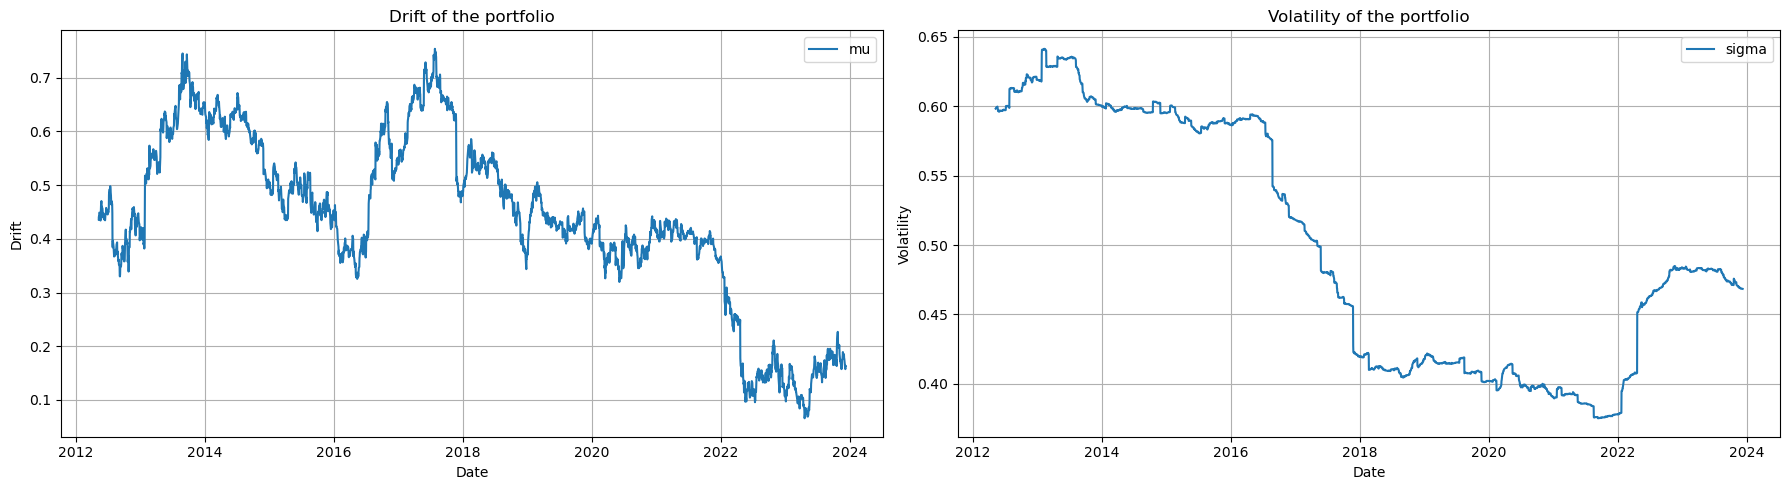

In [8]:
# Test: Calculating mu and sigma using the moving average method
mu, sigma = rms_instance.calculate_mu_sigma(5)
rms_instance.plot_mu_sigma(mu, sigma)

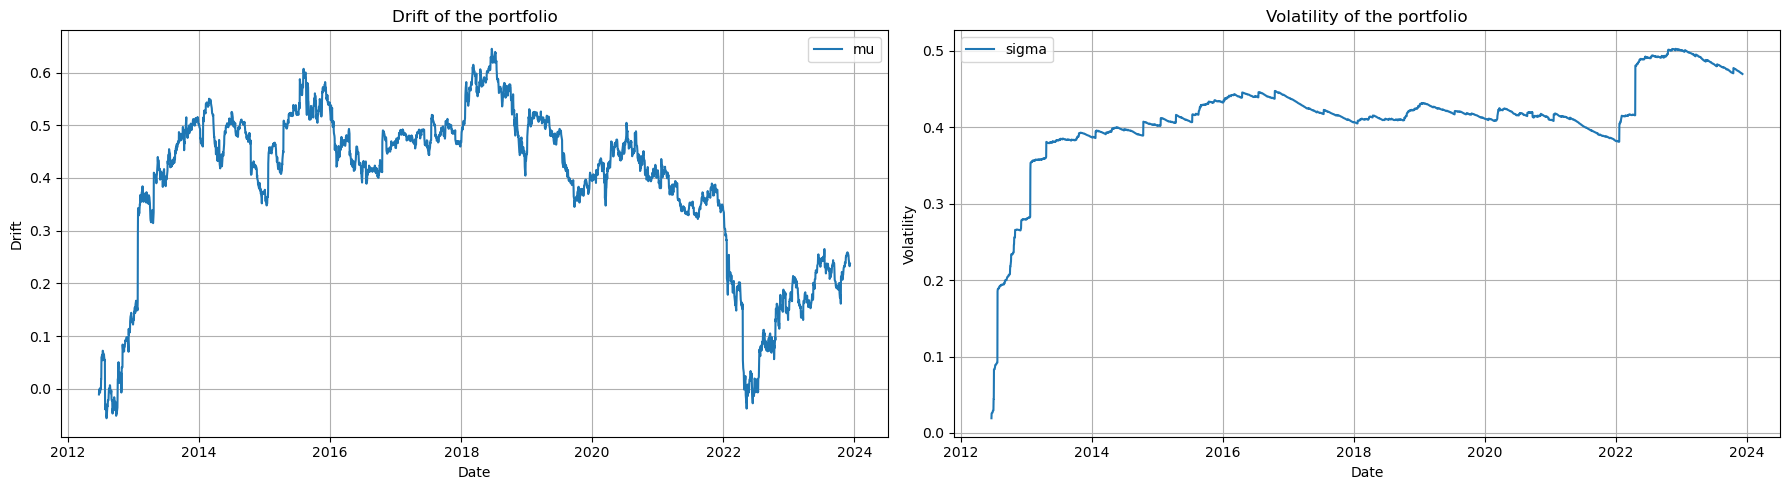

In [9]:
# Test: Calculating mu and sigma using the exponential weighting method
exp_mu, exp_sigma = rms_instance.calculate_exp_mu_sigma(0.9989003714,portfolio)
rms_instance.plot_mu_sigma(exp_mu, exp_sigma)

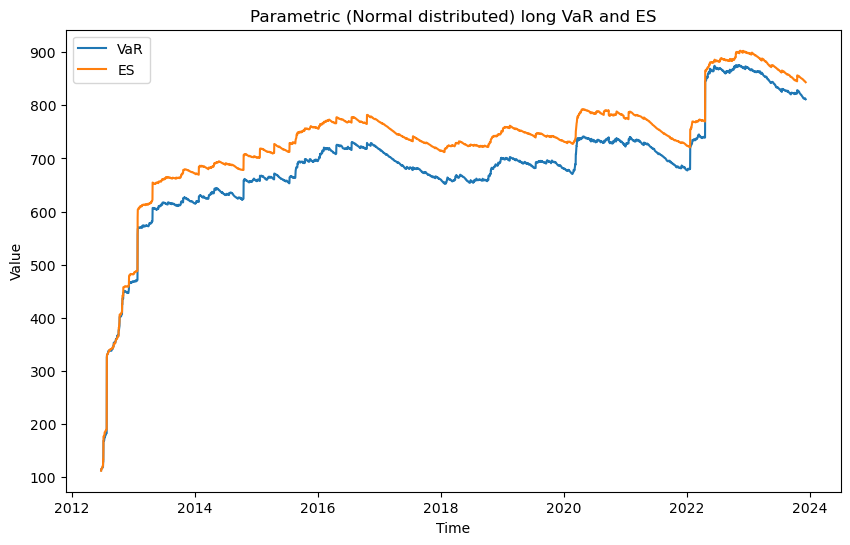

In [10]:
# Test: Parametric VaR / ES assuming normal distributed
rms_instance.plot_VaR_ES('Parametric (Normal distributed)', 'long', exp_mu, exp_sigma)
#rms_instance.plot_VaR_ES('Parametric (Normal distributed)', 'short', exp_mu, exp_sigma)

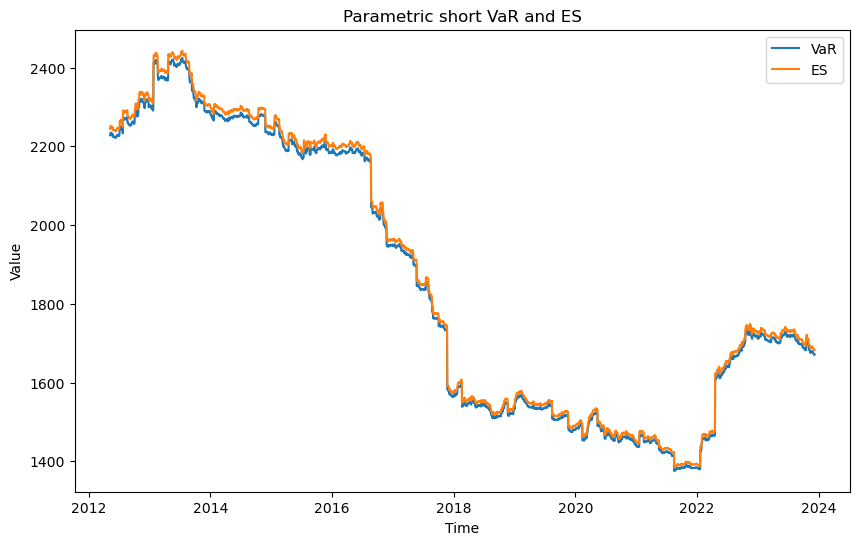

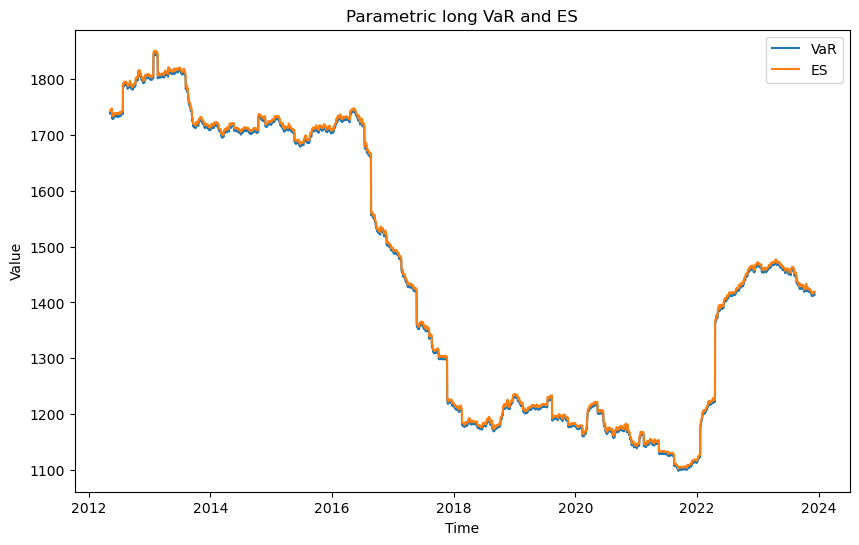

In [11]:
# Test: Parametric VaR / ES with moving average method
rms_instance.plot_VaR_ES('Parametric', 'short', mu, sigma)
rms_instance.plot_VaR_ES('Parametric', 'long', mu, sigma)

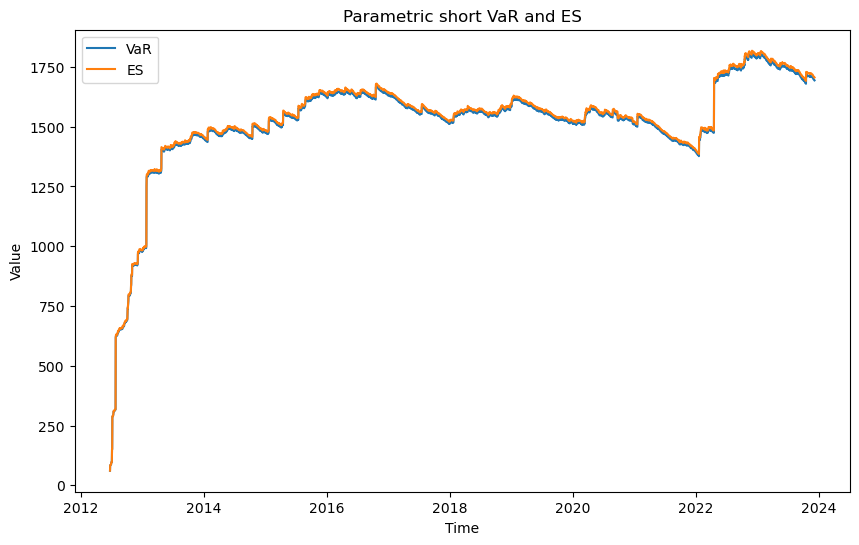

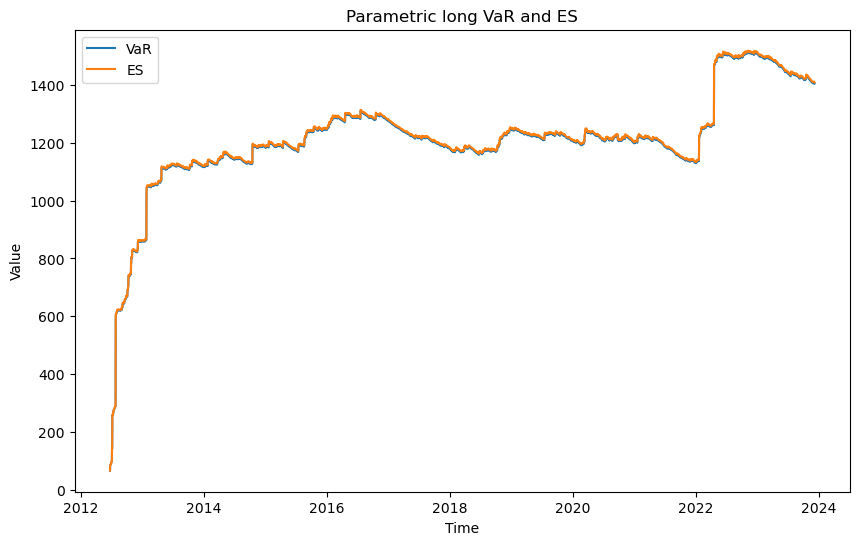

In [12]:
# Test: Parametric VaR / ES with exponential weighting method
rms_instance.plot_VaR_ES('Parametric', 'short', exp_mu, exp_sigma)
rms_instance.plot_VaR_ES('Parametric', 'long', exp_mu, exp_sigma)

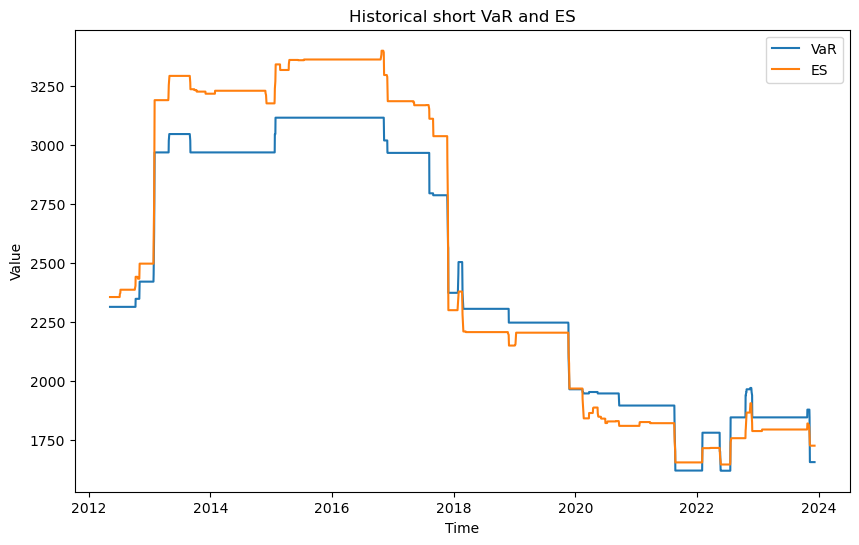

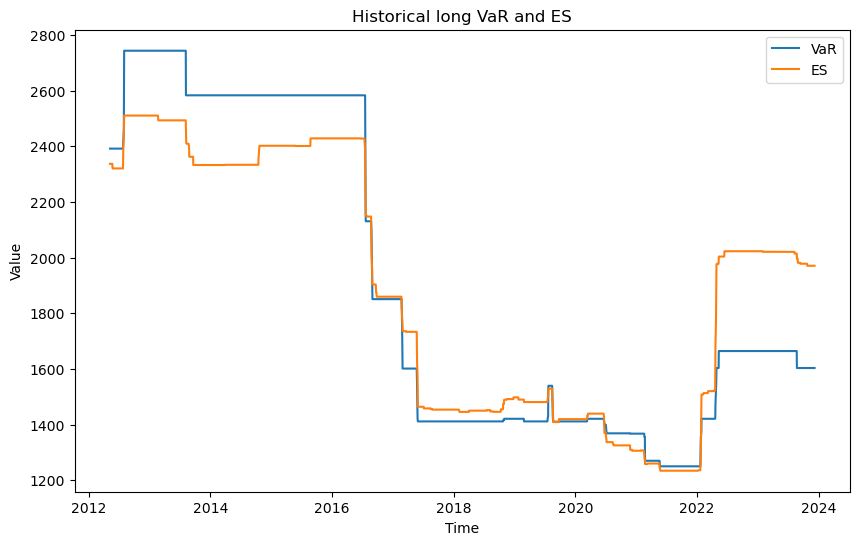

In [13]:
# Test: Historical VaR / ES with moving average method
rms_instance.plot_VaR_ES('Historical', 'short', mu, sigma)
rms_instance.plot_VaR_ES('Historical', 'long', mu, sigma)

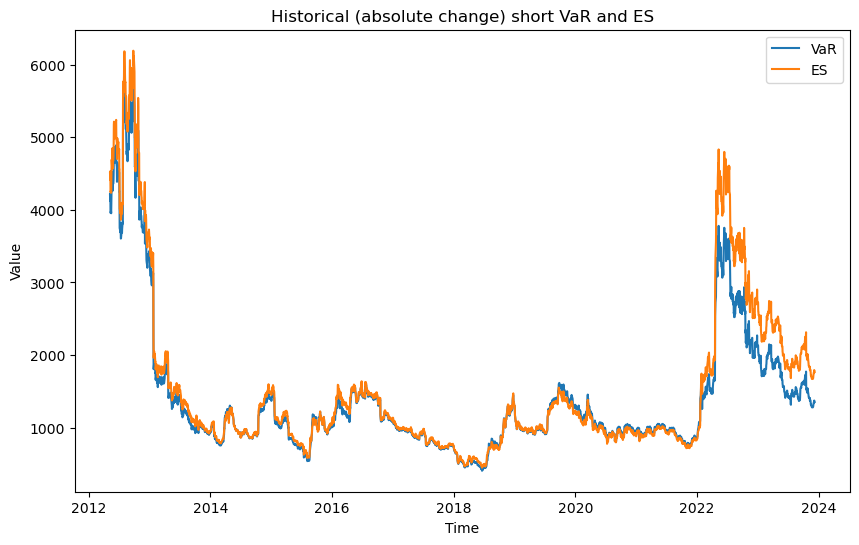

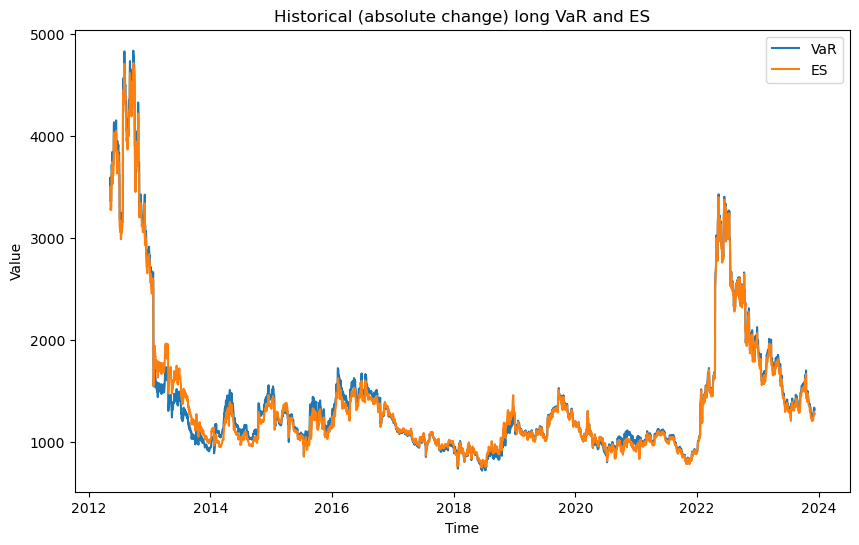

In [14]:
# Test: Historical VaR / ES with absolute change
rms_instance.plot_VaR_ES('Historical (absolute change)', 'short', mu, sigma)
rms_instance.plot_VaR_ES('Historical (absolute change)', 'long', mu, sigma)

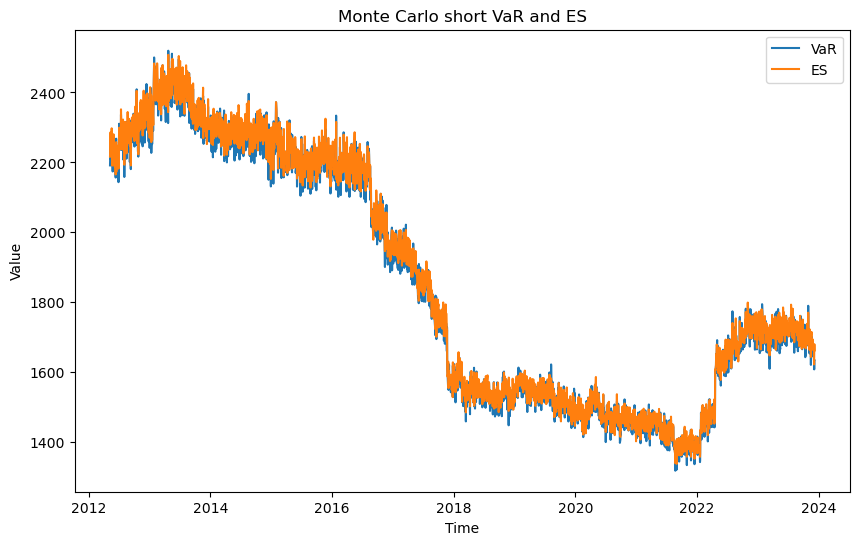

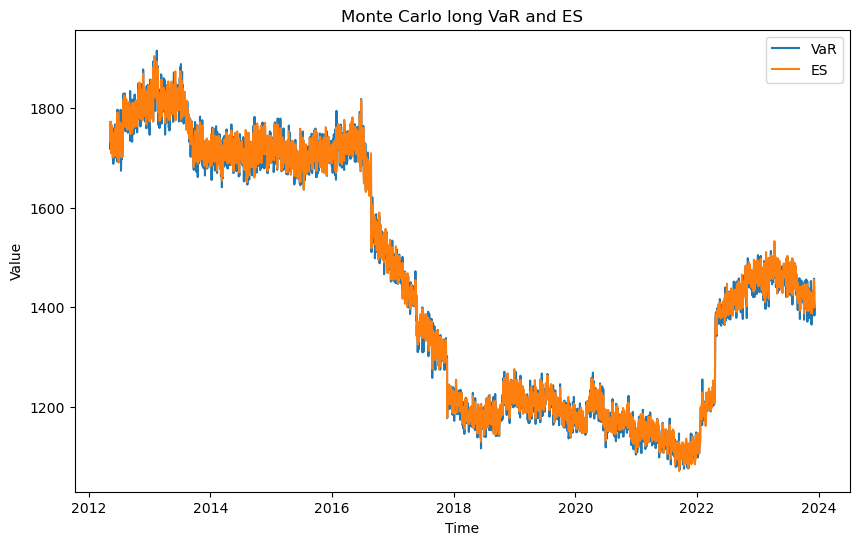

In [15]:
# Test: Monte Carlo VaR / ES with moving average method
rms_instance.plot_VaR_ES('Monte Carlo', 'short', mu, sigma)
rms_instance.plot_VaR_ES('Monte Carlo', 'long', mu, sigma)

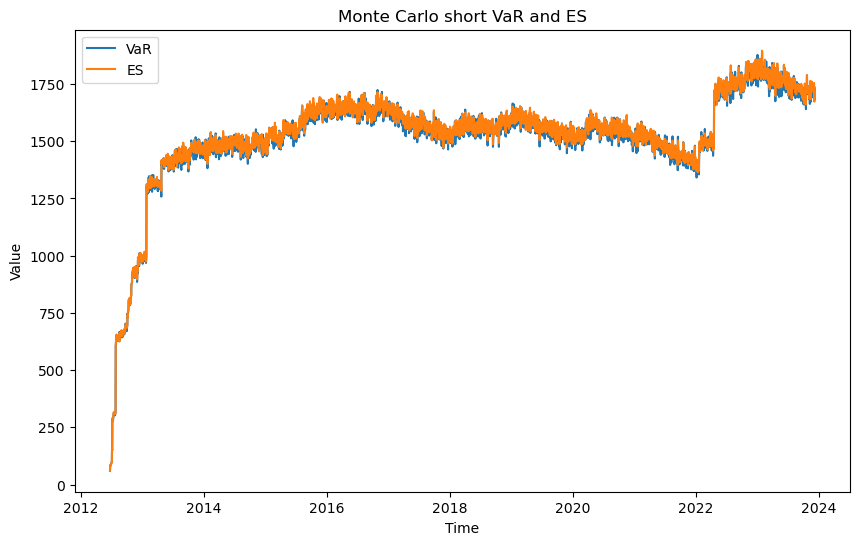

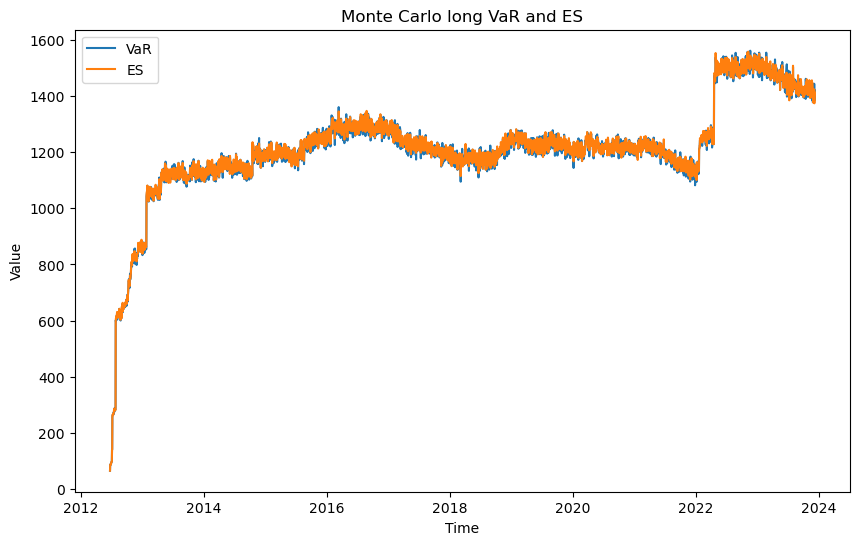

In [16]:
# Test: Monte Carlo VaR / ES with exponential weighting method
rms_instance.plot_VaR_ES('Monte Carlo', 'short', exp_mu, exp_sigma)
rms_instance.plot_VaR_ES('Monte Carlo', 'long', exp_mu, exp_sigma)

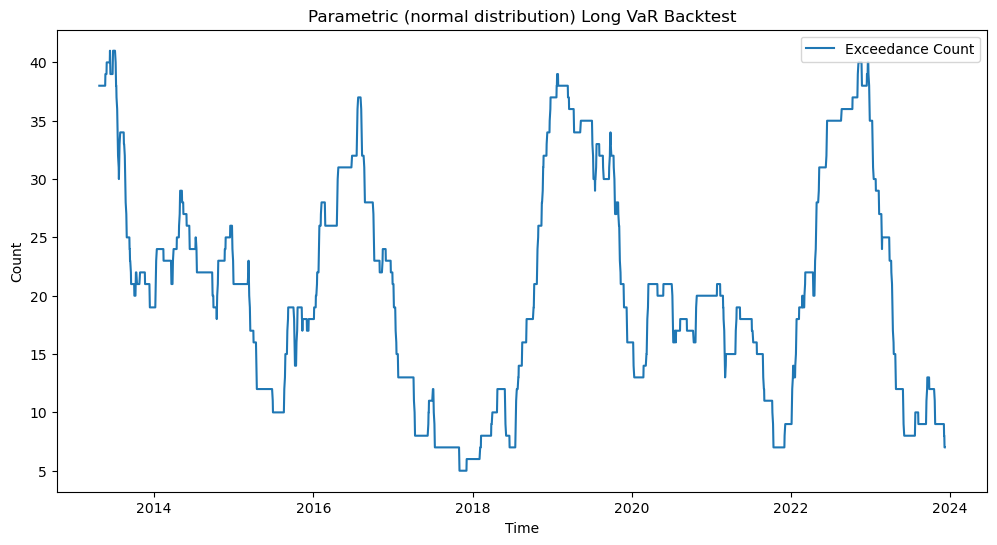

In [17]:
# Test: Backtest Parametric VaR assuming normal distribution
lmbda = 0.9989003714
nor_para_long_VaR = rms_instance.para_normal_dis_long_VaR_ES(lmbda)[0]
#nor_para_short_VaR = rms_instance.para_short_VaR_ES(mu, sigma)[0]
#rms_instance.short_VaR_backtest(nor_para_short_VaR, 'Parametric')
rms_instance.long_VaR_backtest(nor_para_long_VaR, 'Parametric (normal distribution)')

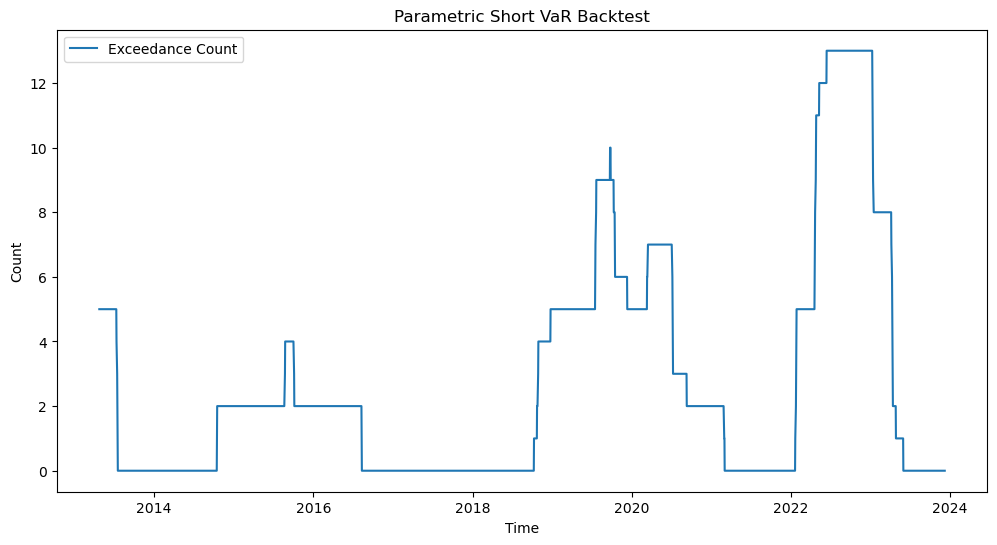

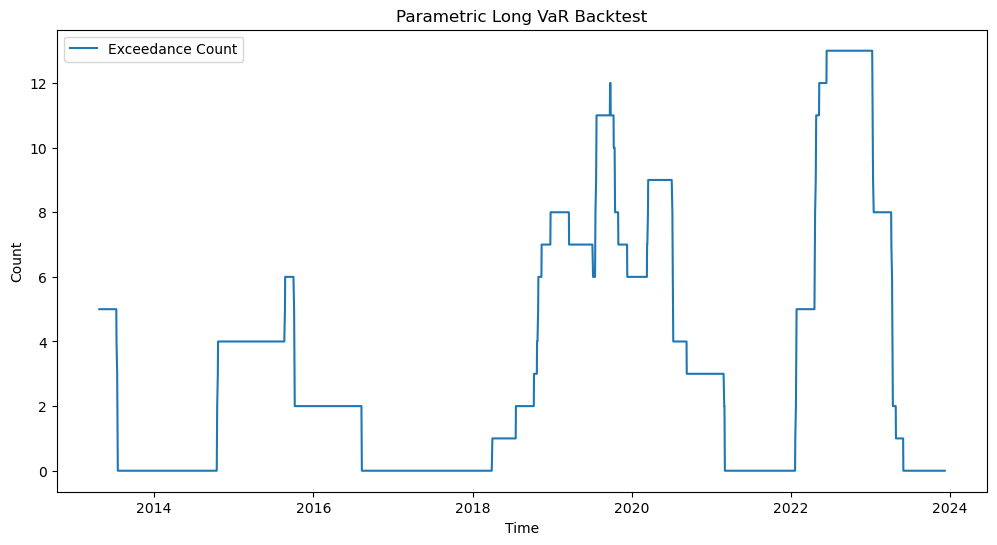

In [18]:
# Test: Backtest Parametric VaR with moving average method
para_long_VaR = rms_instance.para_long_VaR_ES(mu, sigma)[0]
para_short_VaR = rms_instance.para_short_VaR_ES(mu, sigma)[0]
rms_instance.short_VaR_backtest(para_short_VaR, 'Parametric')
rms_instance.long_VaR_backtest(para_long_VaR, 'Parametric')

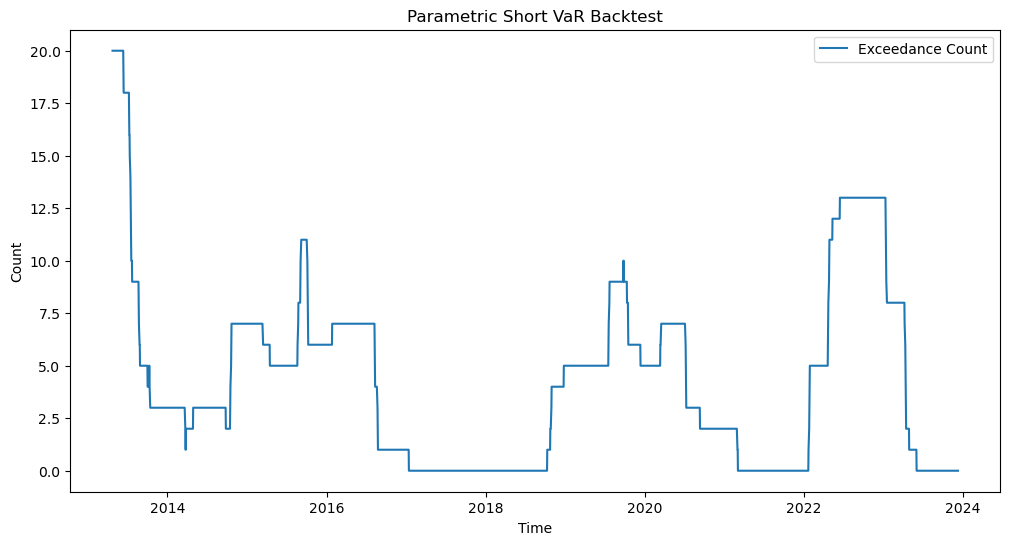

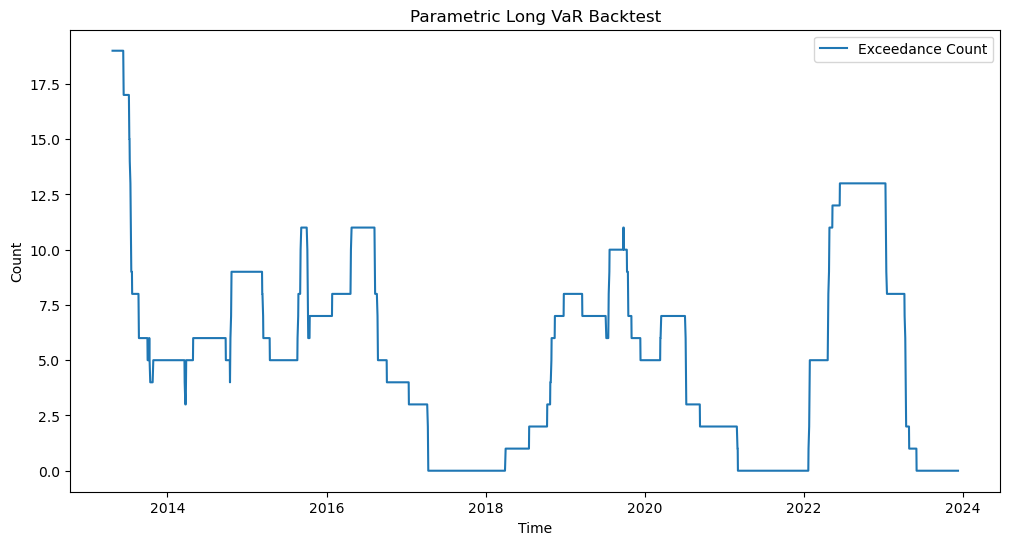

In [19]:
# Test: Backtest Parametric VaR with exponential weighting method
exp_para_long_VaR = rms_instance.para_long_VaR_ES(exp_mu, exp_sigma)[0]
exp_para_short_VaR = rms_instance.para_short_VaR_ES(exp_mu, exp_sigma)[0]
rms_instance.short_VaR_backtest(exp_para_short_VaR, 'Parametric')
rms_instance.long_VaR_backtest(exp_para_long_VaR, 'Parametric')

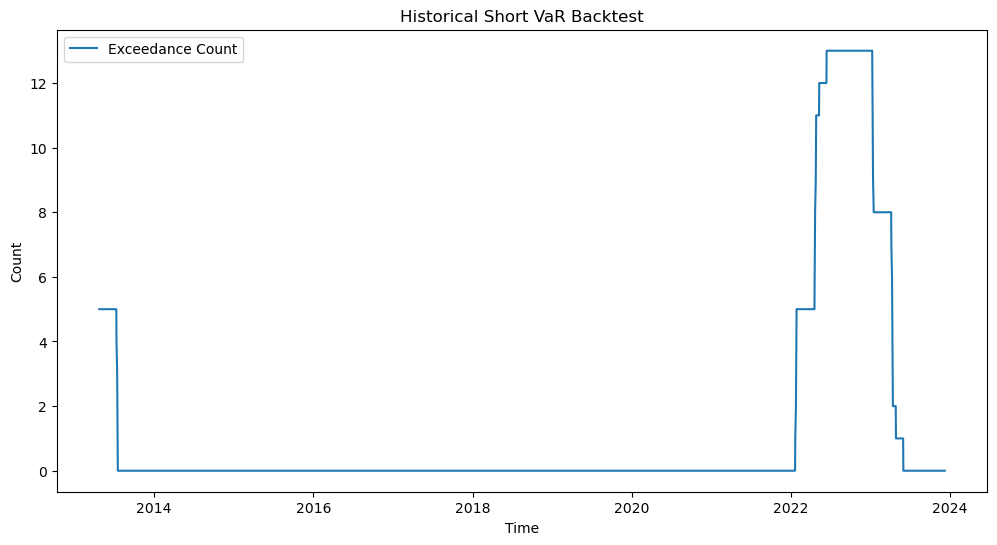

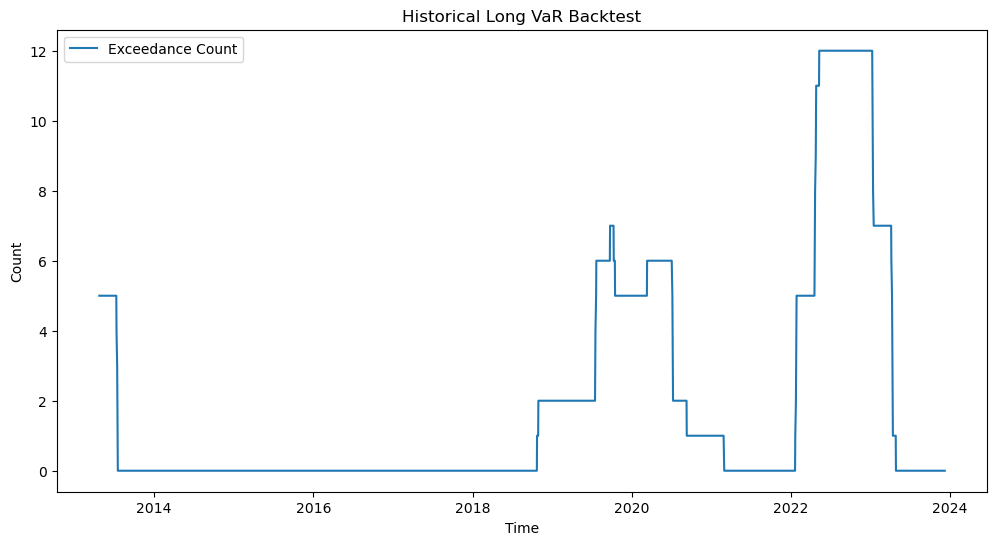

In [20]:
# Test: Backtest Historical VaR with moving average method
hist_long_VaR = rms_instance.hist_long_VaR_ES(mu, sigma)[0]
hist_short_VaR = rms_instance.hist_short_VaR_ES(mu, sigma)[0]
rms_instance.short_VaR_backtest(hist_short_VaR, 'Historical')
rms_instance.long_VaR_backtest(hist_long_VaR, 'Historical')

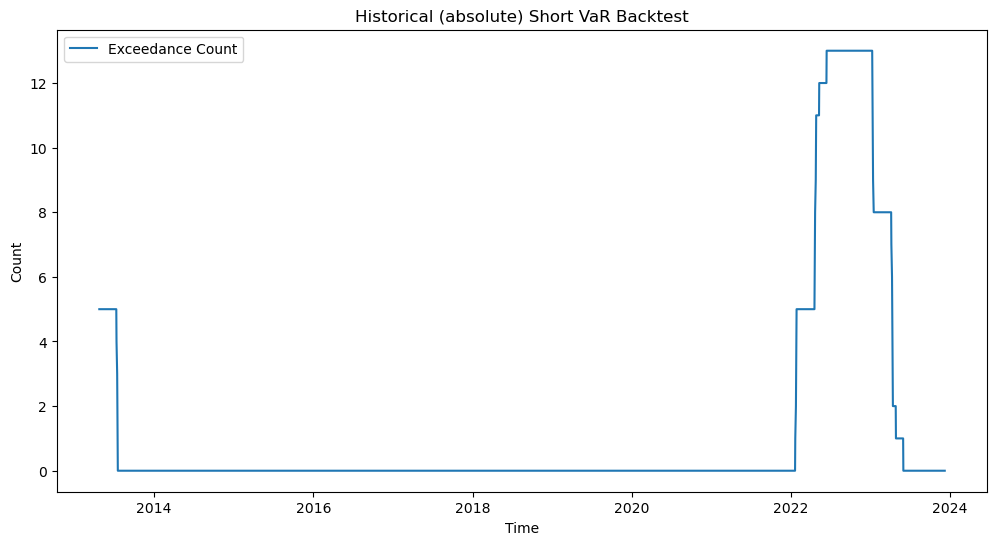

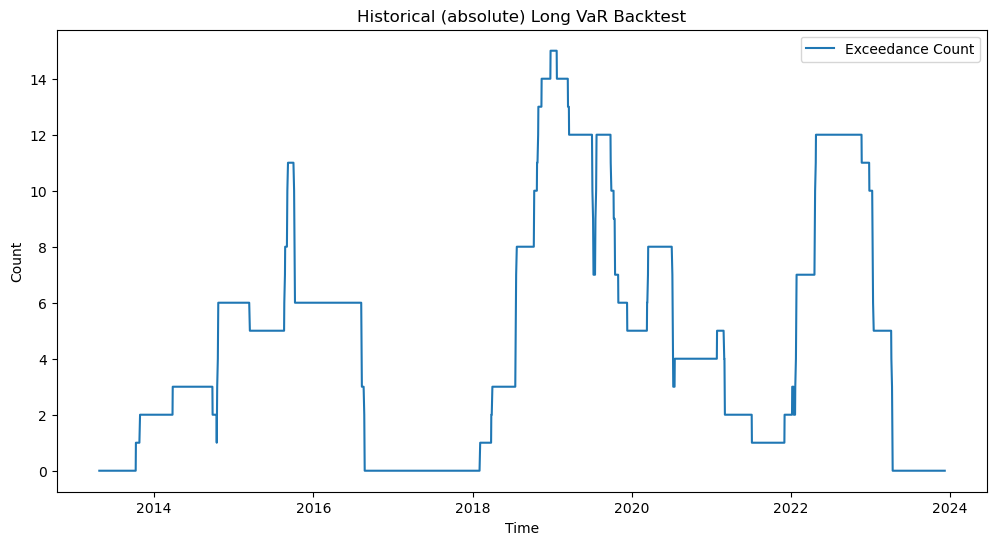

In [21]:
# Test: Backtest Historical VaR assuming absolute change
abs_hist_long_VaR = rms_instance.abs_hist_long_VaR_ES(mu, sigma)[0]
abs_hist_short_VaR = rms_instance.abs_hist_short_VaR_ES(mu, sigma)[0]
rms_instance.short_VaR_backtest(hist_short_VaR, 'Historical (absolute)')
rms_instance.long_VaR_backtest(abs_hist_long_VaR, 'Historical (absolute)')

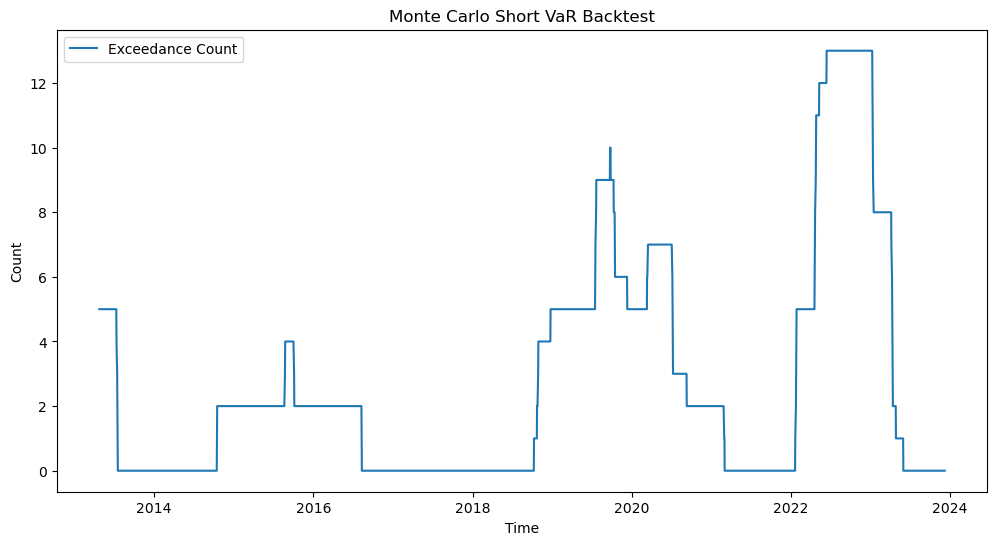

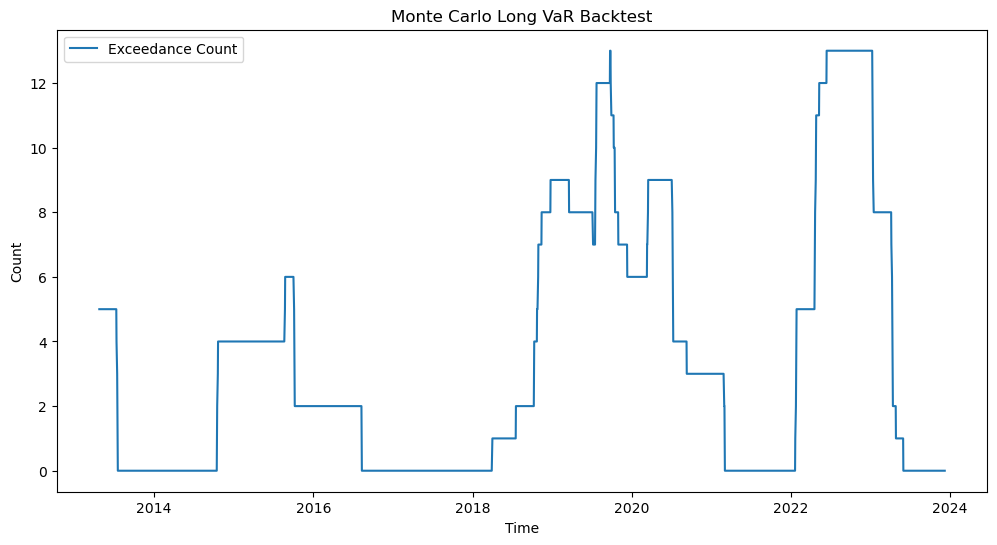

In [22]:
# Test: Backtest Monte Carlo VaR/ES with moving average method
mc_long_VaR = rms_instance.MC_long_VaR_ES(mu, sigma)[0]
mc_short_VaR = rms_instance.MC_short_VaR_ES(mu, sigma)[0]
rms_instance.short_VaR_backtest(mc_short_VaR, 'Monte Carlo')
rms_instance.long_VaR_backtest(mc_long_VaR, 'Monte Carlo')

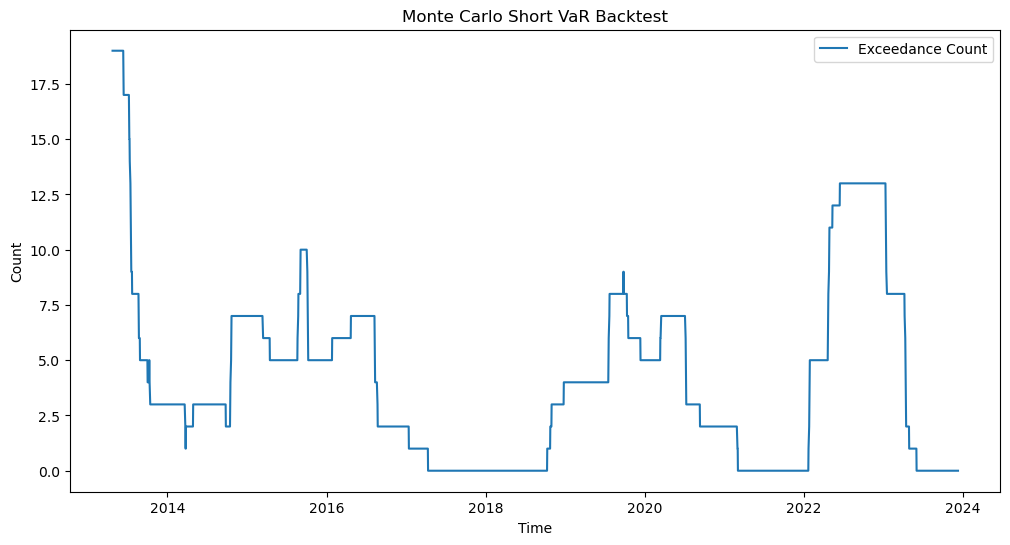

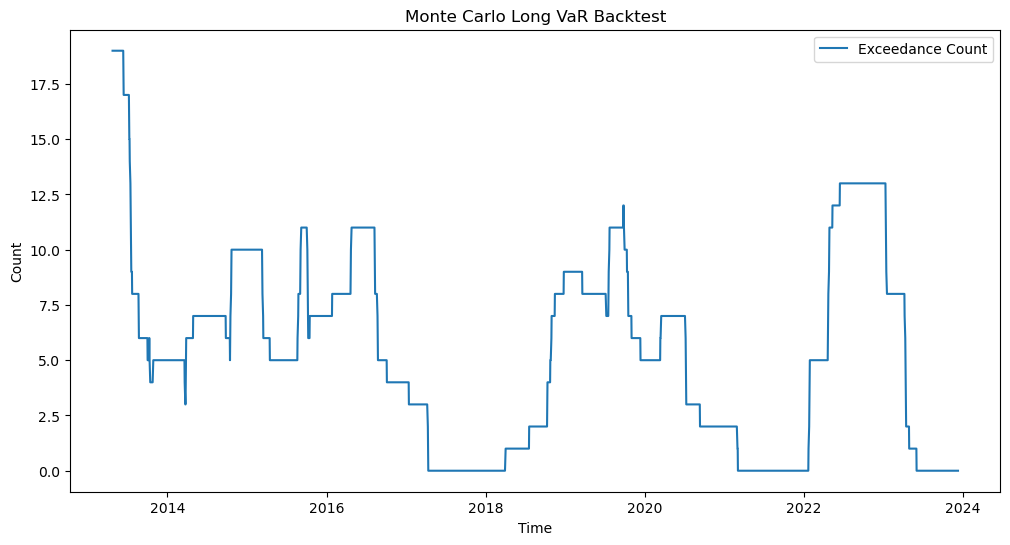

In [23]:
# Test: Backtest Monte Carlo VaR/ES with exponential weighting method
exp_mc_long_VaR = rms_instance.MC_long_VaR_ES(exp_mu, exp_sigma)[0]
exp_mc_short_VaR = rms_instance.MC_short_VaR_ES(exp_mu, exp_sigma)[0]
rms_instance.short_VaR_backtest(exp_mc_short_VaR, 'Monte Carlo')
rms_instance.long_VaR_backtest(exp_mc_long_VaR, 'Monte Carlo')

In [24]:
# Test: Monte Carlo VaR with Moving Average method (with put option)
short_put_VaR = rms_instance.MC_short_put_VaR('KO', mu, sigma)
print('Monte Carlo short put VaR: ')
print(short_put_VaR)
long_put_VaR = rms_instance.MC_long_put_VaR('KO', mu, sigma)
print('Monte Carlo long put VaR: ')
print(long_put_VaR)

Monte Carlo short put VaR: 
1574.7412796848475
Monte Carlo long put VaR: 
1207.2689864047352


In [25]:
# Compare with VaR without put option
VaR_long = rms_instance.para_long_VaR_ES(mu, sigma)[0][-1]
print('Long VaR without put option: ',VaR_long)
per_redu = (VaR_long - long_put_VaR)/VaR_long * 100
print("percentage reduction: ",per_redu)
print('-'*60)

VaR_short = rms_instance.para_short_VaR_ES(mu, sigma)[0][-1]
print('Short VaR without put option: ',VaR_short)
s_per_redu = (VaR_short - short_put_VaR)/VaR_short * 100
print("percentage reduction: ",s_per_redu)

Long VaR without put option:  1413.958572233405
percentage reduction:  14.617796439551633
------------------------------------------------------------
Short VaR without put option:  1671.4802752692103
percentage reduction:  5.787624120708328


In [26]:
# Test: Monte Carlo VaR with Moving Average method (with call option)
short_call_VaR = rms_instance.MC_short_call_VaR('KO', mu, sigma)
print('Monte Carlo short call VaR: ')
print(short_call_VaR)
long_call_VaR = rms_instance.MC_long_call_VaR('KO', mu, sigma)
print('Monte Carlo long call VaR: ')
print(long_call_VaR)

Monte Carlo short call VaR: 
1757.9289674781503
Monte Carlo long call VaR: 
1488.4785723642744


In [27]:
# Compare with VaR without call option
VaR_long = rms_instance.para_long_VaR_ES(mu, sigma)[0][-1]
print('Long VaR without call option: ',VaR_long)
per_redu = (VaR_long - long_call_VaR)/VaR_long * 100
print("percentage reduction: ",per_redu)
print('-'*60)

VaR_short = rms_instance.para_short_VaR_ES(mu, sigma)[0][-1]
print('Short VaR without call option: ',VaR_short)
s_per_redu = (VaR_short - short_call_VaR)/VaR_short * 100
print("percentage reduction: ",s_per_redu)

Long VaR without call option:  1413.958572233405
percentage reduction:  -5.270310007255876
------------------------------------------------------------
Short VaR without call option:  1671.4802752692103
percentage reduction:  -5.171983988564655
